In [8]:
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path("/Users/sai/Desktop/lab_predictors")
DATA_INTERIM = PROJECT_ROOT / "data" / "interim"

df = pd.read_parquet(DATA_INTERIM / "patient_table.parquet")


In [9]:
# exclude patient_id and labels
exclude_cols = ["patient_id", "label_ckd", "label_cvd", "label_anemia", "label_predm"]

features = df.drop(columns=exclude_cols)

# convert sex M/F to numeric
features["sex"] = features["sex"].map({"M": 1, "F": 0})


In [10]:
features.head()


,age,sex,albumin_latest,alt_latest,ast_latest,bilirubin_latest,bun_latest,cholesterol_total_latest,creatinine_latest,egfr_latest,glucose_latest,hba1c_latest,hdl_latest,hematocrit_latest,hemoglobin_latest,ldl_latest,protein_latest,rdw_latest,triglycerides_latest
0,31,0,NaN,NaN,NaN,NaN,NaN,165.85,NaN,NaN,NaN,NaN,52.62,44.295,16.110,86.61,NaN,NaN,133.11
1,31,0,NaN,NaN,NaN,NaN,NaN,165.85,NaN,NaN,NaN,NaN,52.62,44.295,16.110,86.61,NaN,NaN,133.11
2,66,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63,1,NaN,NaN,NaN,NaN,16.46,185.30,0.73,NaN,78.31,5.88,28.71,32.715,11.841,130.69,NaN,NaN,129.53
4,63,1,NaN,NaN,NaN,NaN,16.46,185.30,0.73,NaN,78.31,5.88,28.71,32.715,11.841,130.69,NaN,NaN,129.53


In [11]:
from sklearn.impute import SimpleImputer
import numpy as np

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(features)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


PC1: explained_ratio=0.1163, cumulative=0.1163
PC2: explained_ratio=0.0960, cumulative=0.2123
PC3: explained_ratio=0.0875, cumulative=0.2998
PC4: explained_ratio=0.0739, cumulative=0.3737
PC5: explained_ratio=0.0617, cumulative=0.4354
PC6: explained_ratio=0.0595, cumulative=0.4949
PC7: explained_ratio=0.0570, cumulative=0.5519
PC8: explained_ratio=0.0543, cumulative=0.6062
PC9: explained_ratio=0.0528, cumulative=0.6590
PC10: explained_ratio=0.0520, cumulative=0.7110
PC11: explained_ratio=0.0501, cumulative=0.7611
PC12: explained_ratio=0.0468, cumulative=0.8079
PC13: explained_ratio=0.0456, cumulative=0.8535
PC14: explained_ratio=0.0435, cumulative=0.8969
PC15: explained_ratio=0.0383, cumulative=0.9353
PC16: explained_ratio=0.0256, cumulative=0.9609
PC17: explained_ratio=0.0252, cumulative=0.9861
PC18: explained_ratio=0.0114, cumulative=0.9975
PC19: explained_ratio=0.0025, cumulative=1.0000


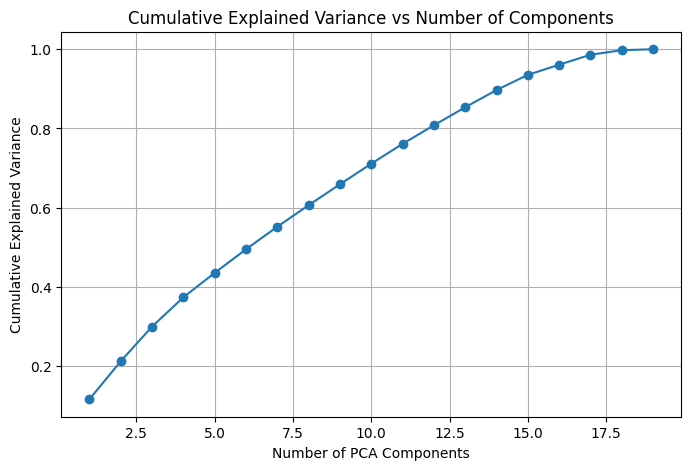

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fit PCA with all possible components
pca_full = PCA()
pca_full.fit(X_scaled)

# Explained variance ratio for each PC
exp_var_ratio = pca_full.explained_variance_ratio_

# Cumulative variance
cum_exp_var = np.cumsum(exp_var_ratio)

# Print some numbers to inspect
for i, (evr, cum) in enumerate(zip(exp_var_ratio, cum_exp_var), start=1):
    print(f"PC{i}: explained_ratio={evr:.4f}, cumulative={cum:.4f}")

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_exp_var) + 1), cum_exp_var, marker="o")
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance vs Number of Components")
plt.grid(True)
plt.show()


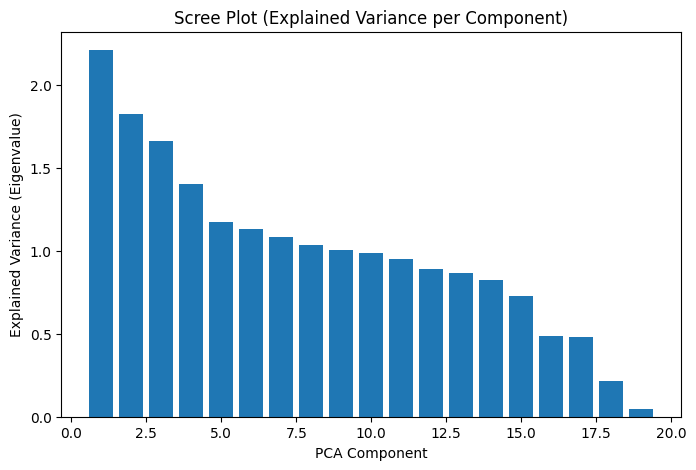

In [14]:
# Eigenvalues (raw explained variance)
exp_var = pca_full.explained_variance_

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(exp_var) + 1), exp_var)
plt.xlabel("PCA Component")
plt.ylabel("Explained Variance (Eigenvalue)")
plt.title("Scree Plot (Explained Variance per Component)")
plt.show()


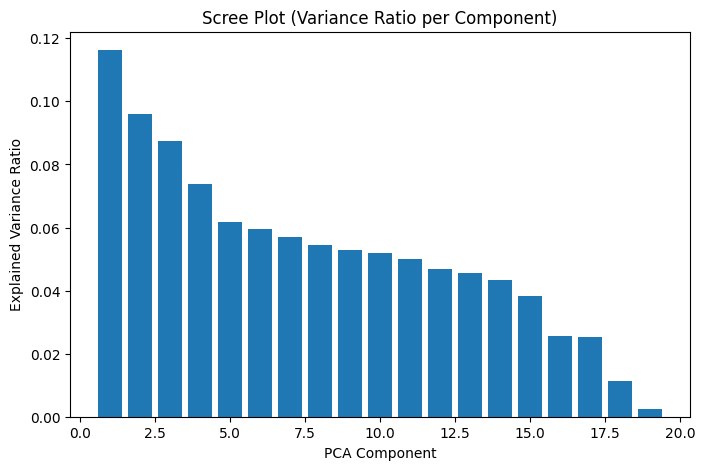

In [15]:
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(exp_var_ratio) + 1), exp_var_ratio)
plt.xlabel("PCA Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot (Variance Ratio per Component)")
plt.show()


In [16]:
from sklearn.decomposition import PCA

# Apply PCA with 14 components (optimal)
pca = PCA(n_components=14)
X_pca = pca.fit_transform(X_scaled)

print("Final total variance captured:", pca.explained_variance_ratio_.sum())


Final total variance captured: 0.8969435790108272


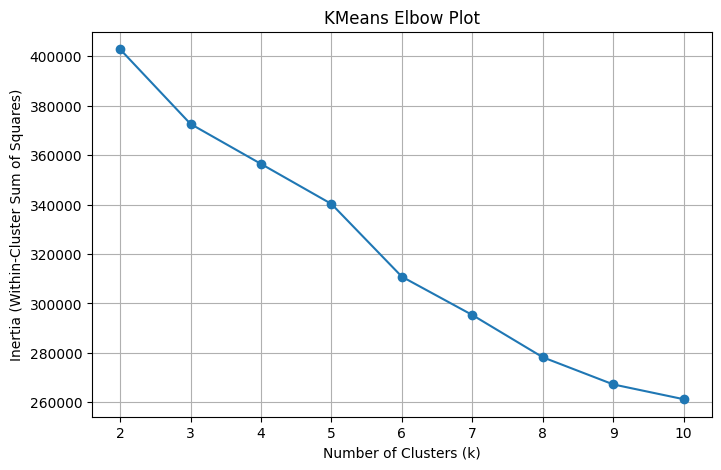

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia_scores.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("KMeans Elbow Plot")
plt.grid(True)
plt.show()


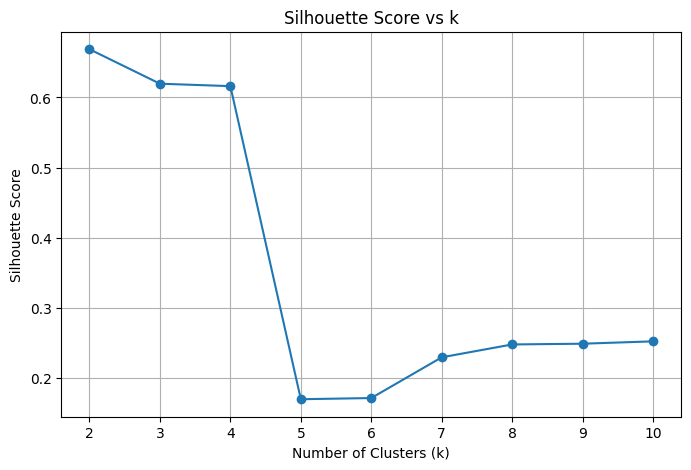

In [18]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    sil_scores.append(sil)

plt.figure(figsize=(8, 5))
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.grid(True)
plt.show()


In [19]:
from sklearn.cluster import KMeans

# Number of clusters from silhouette analysis
k = 4  

kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Attach cluster labels to your original dataframe
df["cluster"] = cluster_labels

# Quick look at cluster sizes
print(df["cluster"].value_counts().sort_index())


cluster
0    23532
1      950
2      390
3      806
Name: count, dtype: int64


In [20]:
from pathlib import Path
import joblib

# -----------------------------------------------------------
# 1. Define project root
# -----------------------------------------------------------
PROJECT_ROOT = Path("/Users/sai/Desktop/lab_predictors")  # Confirm this is correct

# -----------------------------------------------------------
# 2. Ensure folder exists
# -----------------------------------------------------------
MODELS_DIR = PROJECT_ROOT / "models" / "clustering"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("Saving models to:", MODELS_DIR)

# -----------------------------------------------------------
# 3. Save each component of your ML pipeline
# -----------------------------------------------------------
joblib.dump(imputer, MODELS_DIR / "imputer.joblib")
joblib.dump(scaler, MODELS_DIR / "scaler.joblib")
joblib.dump(pca, MODELS_DIR / "pca_14components.joblib")
joblib.dump(kmeans, MODELS_DIR / "kmeans_k4.joblib")

print("Successfully saved imputer, scaler, PCA, and KMeans.")


Saving models to: /Users/sai/Desktop/lab_predictors/models/clustering
Successfully saved imputer, scaler, PCA, and KMeans.


In [21]:
df["sex"] = df["sex"].map({"M": 1, "F": 0})

# Columns we want to summarize (everything except id & labels & cluster)
exclude_cols = ["patient_id", "label_ckd", "label_cvd", "label_anemia", "label_predm", "cluster"]
feature_cols = [c for c in df.columns if c not in exclude_cols]

cluster_feature_means = df.groupby("cluster")[feature_cols].mean()
cluster_label_rates = df.groupby("cluster")[["label_ckd", "label_cvd", "label_anemia", "label_predm"]].mean()

print("=== Feature means per cluster ===")
display(cluster_feature_means)

print("=== Disease label prevalence per cluster ===")
display(cluster_label_rates)


=== Feature means per cluster ===


,age,sex,albumin_latest,alt_latest,ast_latest,bilirubin_latest,bun_latest,cholesterol_total_latest,creatinine_latest,egfr_latest,glucose_latest,hba1c_latest,hdl_latest,hematocrit_latest,hemoglobin_latest,ldl_latest,protein_latest,rdw_latest,triglycerides_latest
cluster,,,,,,,,,,,,,,,,,,,
0,40.287566,0.495368,4.751846,156.8400,123.9000,0.847442,13.586312,168.707049,1.308136,78.407338,81.521578,6.070432,51.396293,42.043683,14.658066,93.838431,7.129510,13.47950,126.215398
1,56.980000,0.455789,4.631788,134.3425,189.7525,1.869279,13.452575,252.596042,1.226064,99.117881,98.421040,6.105549,48.336489,41.901161,14.548083,174.961347,7.279312,13.45975,153.963484
2,61.179487,0.502564,4.562794,NaN,NaN,10.905840,13.424385,183.608750,2.009645,15.680951,85.567639,5.579425,48.972474,41.676613,14.171964,107.326320,6.931512,NaN,136.012006
3,70.935484,0.545906,4.131510,112.3850,153.9750,0.966986,13.389814,185.072103,2.515858,60.317721,85.547756,4.212496,50.912559,41.889911,14.513872,114.461742,6.969578,12.13275,140.773766


=== Disease label prevalence per cluster ===


,label_ckd,label_cvd,label_anemia,label_predm
cluster,,,,
0,0.006629,0.053714,0.082568,0.090770
1,0.101053,0.507368,0.557895,0.616842
2,0.128205,0.769231,0.453846,0.566667
3,0.564516,0.823821,0.614144,0.678660


/var/folders/q7/05m0g3px51q0hh1_jv3nmjkw0000gn/T/ipykernel_57278/228760448.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


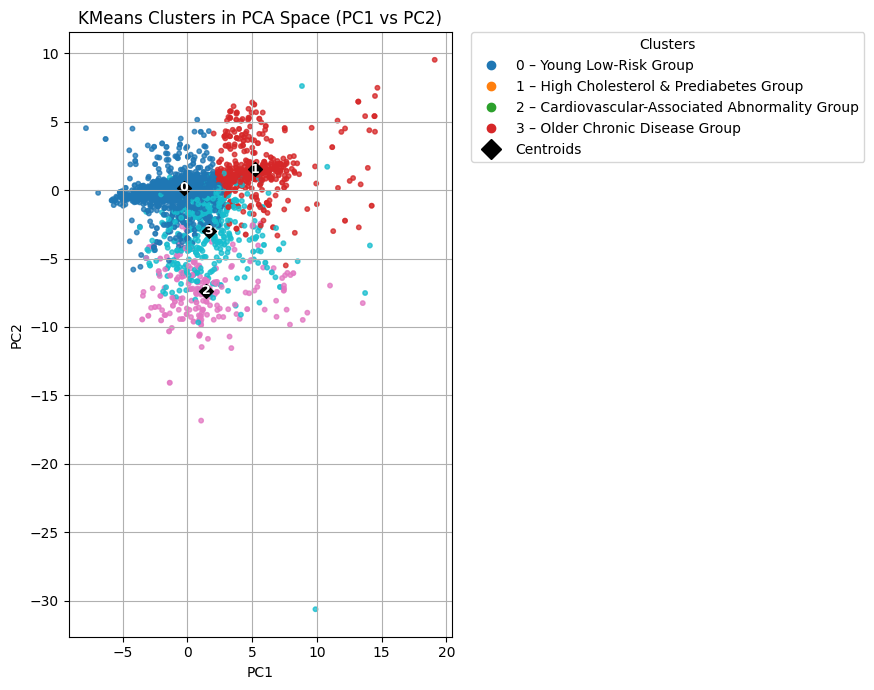

In [22]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 1) Define human-friendly cluster names
cluster_names = {
    0: "Young Low-Risk Group",
    1: "High Cholesterol & Prediabetes Group",
    2: "Cardiovascular-Associated Abnormality Group",
    3: "Older Chronic Disease Group",
}

plt.figure(figsize=(9, 7))

# 2) Scatter plot of patients in PCA space (PC1 vs PC2)
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=cluster_labels,
    cmap="tab10",
    alpha=0.5,
    s=10,
)

# 3) Plot centroids in PCA space (diamond marker)
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c="black",
    s=50,
    marker="D",     # <-- diamond marker
    label="Centroids",
)

# 4) Annotate centroids with cluster IDs
for cid, center in enumerate(centers):
    plt.text(
        center[0],   # x = PC1
        center[1],   # y = PC2
        str(cid),
        color="white",
        ha="center",
        va="center",
        fontsize=9,
        fontweight="bold",
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters in PCA Space (PC1 vs PC2)")
plt.grid(True)

# 5) Build a legend mapping colors → cluster names
handles = []
unique_clusters = sorted(set(cluster_labels))
cmap = plt.cm.get_cmap("tab10")

for cid in unique_clusters:
    handles.append(
        Line2D(
            [],
            [],
            marker="o",
            linestyle="",
            color=cmap(cid),
            label=f"{cid} – {cluster_names.get(cid, f'Cluster {cid}')}",
        )
    )

# Diamond centroid in legend
handles.append(
    Line2D(
        [],
        [],
        marker="D",
        linestyle="",
        color="black",
        label="Centroids",
        markersize=10,
    )
)

plt.legend(
    handles=handles,
    title="Clusters",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()


In [23]:
from pathlib import Path
import pandas as pd

# Your project root — adjust if needed
PROJECT_ROOT = Path("/Users/sai/Desktop/lab_predictors")

# Path to processed folder
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# Create the folder if it does not exist
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# Save df (which must contain the 'cluster' column)
df.to_parquet(DATA_PROCESSED / "patient_table_with_clusters.parquet", index=False)

print("Saved processed file with clusters:")
print(DATA_PROCESSED / "patient_table_with_clusters.parquet")


Saved processed file with clusters:
/Users/sai/Desktop/lab_predictors/data/processed/patient_table_with_clusters.parquet
